In [18]:
import sys
#  Change la ligne suivante pour ton propre pc
sys.path.append('C:/Users/utric/Documents/GitHub/vlf_mri/')  

import numpy as np
import vlf_mri
from pathlib import Path
from scipy import optimize
from scipy import special
from lmfit import Model, Parameters
import matplotlib.pyplot as plt

def get_r11(R1, ilt):
    """Extrait les R1 d'une distribution. Ça marche à peu près bien pour les données avec une seule population.
    Si les données ont plus de 1 population, une solution peut être de découper les ilt en deux.
    
    ilt_bas_R1 = ilt_data[:n]"
    ilt_haut_R1 = ilt_data[n:]
    
    où tu as choisi n tel qu'il y ait une population dans [:n] et une autre population dans la coupe [n:].
    
    Puis de lancer ce code sur chaque bout de ilt.
    """
    
    def my_fun(R1, mu, sigma, A):
        return A * np.exp(-(R1-mu)**2/sigma**2)
    
    R1_1 = []
    for ilt_i in ilt:
        mod = Model(my_fun, independent_vars=["R1"])
        
        mu0 = R1[np.argmax(ilt_i[:-20])] # Initial guess
        
        params = Parameters()
        params.add('A', value=0.05, min=0.)
        params.add('mu', value=mu0, min=0)
        params.add('sigma', value=1, min=0)

        res = mod.fit(ilt_i, params, R1=R1)
        R1_1.append(res.params["mu"].value)
    
    R1_1 = np.array(R1_1)
    return R1_1

def plot_r11(B_relax, R11):  # Affichage de courbes R1
    plt.figure(figsize=(8/2.54,8/2.54))
#     plt.loglog(B_relax, R11, "o-")
    plt.scatter(B_relax, R11, facecolors='none', edgecolors='b', linewidths=0.8, s = 20)
    plt.ylabel(r"$R_{11}$ [s$^{-1}$]")
    plt.xlabel(r"Frequence [MHz]")
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([5e0, 5e3])
    plt.show()

In [19]:
# Chemin de données que tu veux caractériser
folder = Path("relax_test_data")
# file = folder / "Sang_total_AC.sdf"
file = folder / "sang_total-2021-21-10_-18C-solide2.sdf"


# Import de données
fid_data = vlf_mri.import_sdf_file(file)
# fid_data = vlf_mri.import_sdf2_file(file)  # Si sdf version 2


Importing datafile: relax_test_data\sang_total-2021-21-10_-18C-solide2.sdf


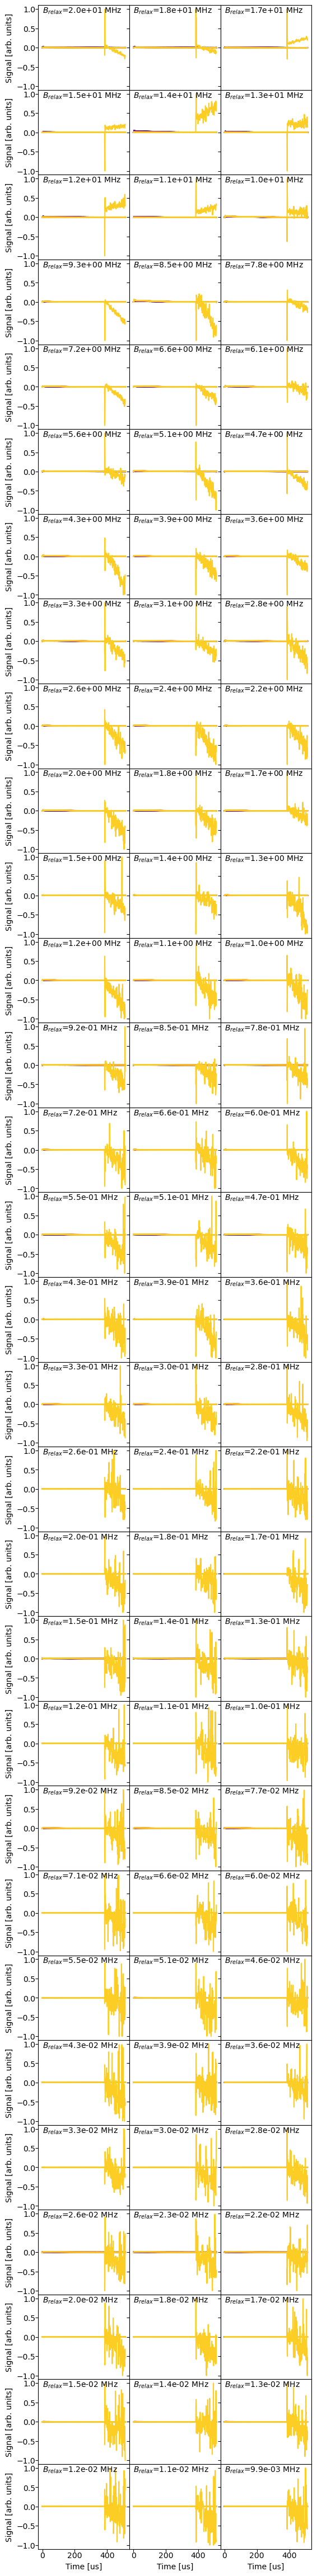

In [3]:
# fid_data.batch_plot()

In [20]:
mag_data = fid_data.to_mag_mean()


In [ ]:
# mag_data.batch_plot()

# Choix des paramètres de la ILT

<dl>
    <dt>R1</dt>
        <dd>valeurs de R1 pour lesquels tu souhaites faire la ilt </dd>
    <dt>lmd</dt>
        <dd>valeur de l'hyperparamètre -> essaie plusieurs valeurs sur plusieurs échelles de grandeur (important!)</dd>
    <dt>order</dt>
        <dd>Ordre de la dérivée pour la fonction de régularisation. Les Italiens utilisent 2 (dérivée seconde), Jean-Pierre utilise 0. Ça va influencer la forme des pics, mais pas forcément leurs positions. N.B. Le lmd optimal va changer en fonction de ce paramètre</dd>  
    <dt>penalty</dt>
    <dd>"c" (constant, ou aucune) ou "up" (uniform penalty). Les italiens proposent "up", 
Jean-Pierre utilise "c", en pratique ça ne modifie pratiquement pas le résultat.
Je suggère de laisser "c". </dd>
</dl>

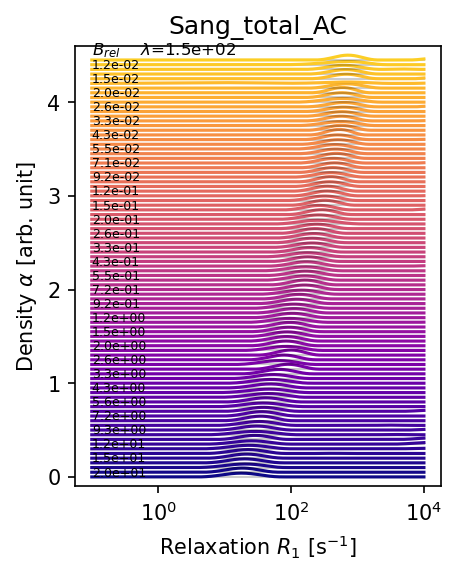

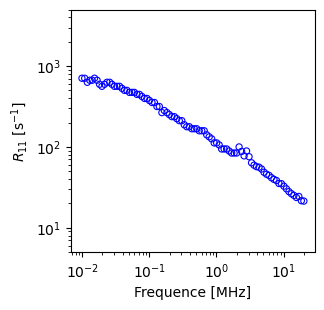

In [23]:
R1 = np.logspace(-1, 4, 201)

lmd = 15e1 
order = 2 
penalty = "c"

ilt_data = mag_data.to_ilt(R1, lmd=lmd, reg_order=order, penalty=penalty)
ilt_data.batch_plot("Sang_total_AC")  

ilt = ilt_data.data
R11_1 = get_r11(R1, ilt) # Fonction définie plus haut dans le code
plot_r11(B_relax, R11_1)

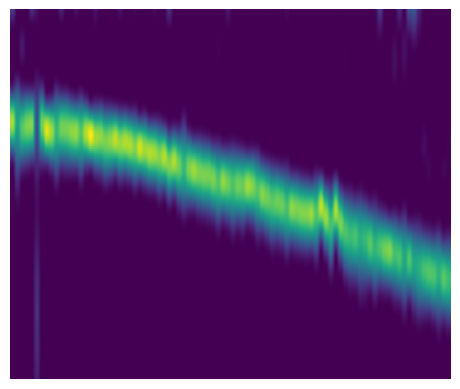

In [10]:
# Visualisation en image. Faut voir si on veut faire comme ça, ou faire comme Jean-Pierre.
xmin = B_relax.min()
xmax = B_relax.max()
ymin = R1[50:].min()
ymax = R1.max()
plt.imshow(np.rot90(ilt,-1)[50:] ,origin='lower', aspect=0.5)

d = np.log(R11_1[::-1])
# d = (d-d.min())/(d.max()-d.min())*len(ilt[50:].T)/3+38
# plt.plot(d, c="w")
# plt.xscale('log')
# plt.yscale('log')
plt.axis("off")
plt.show()